# CNNs

### Loading the mnist dataset
**With the purpose of distinguishing 3s from 7s**

In [24]:
from fastai.vision.all import *
import matplotlib
matplotlib.rc('image', cmap='Greys')

path = untar_data(URLs.MNIST_SAMPLE)

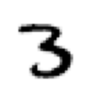

In [25]:
Path.BASE_PATH = path
im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3);

In [26]:
im3.shape

(28, 28)

In [27]:
#Creating a dataloader
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                get_items = get_image_files,
                splitter = GrandparentSplitter(),
                get_y = parent_label)

dls = mnist.dataloaders(path)
xb, yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

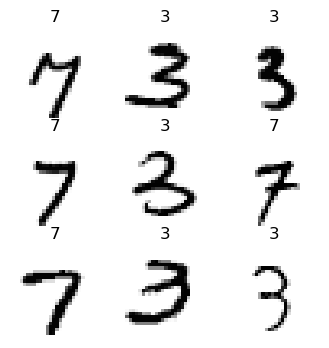

In [46]:
dls.show_batch(figsize=(4,4))

One batch contains 64 images, each of 1 channel, with 28×28 pixels (ONLY 3 and 7s)

A *channel* is a single basic color in an image—for regular full-color images there are three channels, red, green, and blue. PyTorch represents an image as a rank-3 tensor, with dimensions `[channels, rows, columns]`.

In [28]:
# By default, fastai puts data on the GPU - but I don't have any :-)
xb,yb = to_cpu(xb),to_cpu(yb)

#### Basic neural net

In [29]:
import torch
from torch import nn
import torch.nn.functional as F

simple_nn = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

In [30]:
simple_nn

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

### CNN
Using **nn.Conv2d(in_channels, out_channels, kernel_size, more..)** instead of F.conv2d because the module automatically initializes the weights and biases (alternatively we would have to define them ourselves and pass them as arguments to F.conv2d)

The parameters kernel_size, stride, padding, dilation can either be:
- a single int – in which case the same value is used for the height and width dimension
- a tuple of two ints – in which case, the first int is used for the height dimension, and the second int for the width dimension

**Out channels:**

The number of output channels, **also called features, is the number of filters that will be applied to the input image**. Each filter is a different set of weights and biases that will be learned by the CNN. The more filters we have, the more patterns we can detect, but the more computationally expensive our model will be.

In [31]:
broken_cnn = nn.Sequential(
    #in_channels = 1, out_channels = 30, kernel size = 3x3
    #padding = 1 means that the output will be the same size as the input
    nn.Conv2d(1,30, kernel_size=3,padding=1),
    nn.ReLU(),
    #in_channels = 30, out_channels = 1, kernel size = 3x3
    nn.Conv2d(30,1, kernel_size=3,padding=1)
)

One thing to note here is that we didn't need to specify 28×28 as the input size. That's because a linear layer needs a weight in the weight matrix for every pixel, so it needs to know how many pixels there are, but a convolution is applied over each pixel automatically. The weights only depend on the number of input and output channels and the kernel size, as we saw in the previous section.

In [32]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

The output cannot be used for classification as we have 28 x 28 map of activations. One way to deal with this, is to add enough stride-2 convolutions (halves the size of the image) to reduce the size of the final map to 1 x 1. 

In [33]:
#Define a function to create each convolutional layer

def conv(n_inputs, n_features, ks=3, activation=True):
    res = nn.Conv2d(n_inputs, n_features, stride=2, kernel_size=ks, padding=ks//2)
    if activation: 
        res = nn.Sequential(res, nn.ReLU())
    return res

In [34]:
#Due to stride=2 the image size is reduced by half in each layer (rounded up if uneven)
#At the same time, we increase the number of features (channels) by a factor of 2 to compensate for the loss of information

#Assuming input size of 28x28
simple_cnn = nn.Sequential(
    conv(1, 4),            #14x14
    conv(4, 8),            #7x7
    conv(8, 16),           #4x4
    conv(16, 32),          #2x2
    conv(32, 2, activation=False), #1x1
    nn.Flatten(),
)

In [35]:
simple_cnn(xb).shape

torch.Size([64, 2])

After which the learner can now be created

In [36]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

As seen in the summary, the first layer has dim 64x1x28x28, the axis are batch_size, channels, height, width - often written NCHW (in tensorflow written NHWC).

In [37]:
learn.fit_one_cycle(4,0.01)
# https://iconof.com/1cycle-learning-rate-policy/

epoch,train_loss,valid_loss,accuracy,time
0,0.088740,0.057085,0.982826,00:03
1,0.033054,0.029957,0.989205,00:03
2,0.013426,0.021099,0.994112,00:04
3,0.005614,0.015866,0.996075,00:04


99% accuracy of distinguishing 3s and 7s

In [40]:
# Get predictions for the validation set
preds, targets = learn.get_preds()

# You can print the predictions and targets here, or use them in any other way you need.
print("Predictions:", preds)
print("Targets:", targets)

Predictions: tensor([[ -3.9970,   3.9819],
        [ -3.6331,   3.5064],
        [ -6.1979,   6.2633],
        ...,
        [  5.8384,  -6.4491],
        [ 13.0279, -12.8226],
        [  5.5979,  -6.4949]])
Targets: tensor([1, 1, 1,  ..., 0, 0, 0])


The preds tensor will contain the raw probabilities for each class, and targets will contain the true labels. You can convert the probabilities to class indices using the argmax method if you need the actual predicted classes.

Predicted: 3, Actual: 7
Predicted: 3, Actual: 7
Predicted: 3, Actual: 7
Predicted: 3, Actual: 7
Predicted: 3, Actual: 7


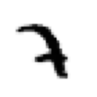

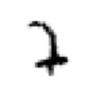

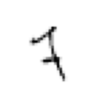

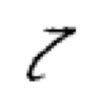

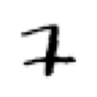

In [43]:
from fastai.vision.core import show_image

# Convert the probabilities to class indices
predicted_classes = preds.argmax(dim=1)

# Find indexes where predictions do not match the targets
misclassified_idxs = (predicted_classes != targets).nonzero(as_tuple=False).squeeze()

# Show some misclassified images
for idx in misclassified_idxs[:5]: # showing first 5 misclassified samples
    img, label = dls.valid_ds[idx]
    pred_label = dls.vocab[predicted_classes[idx]]
    actual_label = dls.vocab[label]
    print(f"Predicted: {pred_label}, Actual: {actual_label}")
    show_image(img)

## Understanding convolution arithmetic


In [48]:
#First convolutional layer:
m = learn.model[0]
m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

1 input channel, 4 output channels (features), and a 3x3 kernel.
Let's check the weight of the first convolutions.

In [49]:
m[0].weight.shape

torch.Size([4, 1, 3, 3])

In [52]:
#These are the 4 3x3 kernels and their weights
m[0].weight

Parameter containing:
tensor([[[[ 0.2703, -0.0702, -0.2322],
          [ 0.0871, -0.2465, -0.3545],
          [-0.0098,  0.0213,  0.3326]]],


        [[[ 0.1684,  0.3588,  0.3966],
          [ 0.0308,  0.4624,  0.2193],
          [-0.0758,  0.0491,  0.1905]]],


        [[[-0.3600, -0.1267, -0.7243],
          [-0.0371, -0.2817, -0.0843],
          [ 0.0385,  0.1798, -0.3322]]],


        [[[-0.1415,  0.1849,  0.1873],
          [ 0.4169,  0.2084,  0.0023],
          [ 0.5522,  0.5500,  0.5025]]]], requires_grad=True)

That is, 4 x 1 x 3 x 3 = 36 parameters. The 4 comes from the fact that there are 4 filters. The 1 comes from the fact that the input depth is 1. The 3 x 3 comes from the size of the filters. That could indicate 36 parameters of this layer, but if we go up and inspect, it can be seen that there is in fact 40 paramters in the first layer:


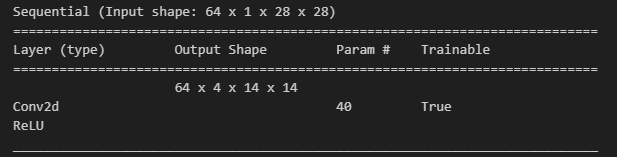

That is because the biases, there is in addition **1 bias per channel/feature**, and it is is stored seperately,

In [50]:
m[0].bias.shape

torch.Size([4])

### Calculations per layer, increasing number of channels/features when applying stride-2
The output shape of the first layer is 64 x 4 x 14 x 14, and the next layer has 296 paramters (including 8 biases), so if we simplify things a little and ignore batch size as well as the biases, it means that we will multiply 14x14 = 196 locations with 296-8=288 wieghts = 56.448 multiplications. The third layer will ahve 7x7x(1168-16) = 56.448 calculations. 

As seen, the above CNN structure keeps the amount of computations equal, because the number of features/channels is doubled as the number of activations is halved (actual number  of calculatins decreased/increased by a factor of 4).


## Color images

In [55]:
im = image2tensor(Image.open('bear_ex.jpg'))
im.shape


torch.Size([3, 600, 1000])

<Axes: >

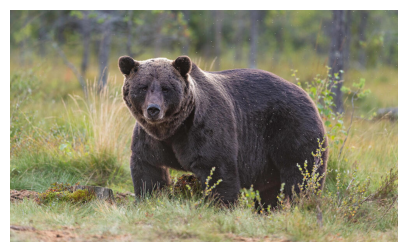

In [56]:
show_image(im)

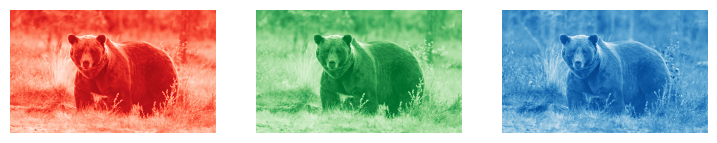

In [57]:
_,axs = subplots(1,3)
for bear,ax,color in zip(im,axs,('Reds','Greens','Blues')):
    show_image(255-bear, ax=ax, cmap=color)
     

When applying Kernels to RGB images, we need 3 filters (one for each channel), but the values of these kernels are not the same.
The kernel therefore needs to have dimension 3 x 3 x 3 in this case (3 channels, 3x3 kernel size).  On each color channel, we multiply the kernel with the corresponding sliding window, then sum the result, and finally sum over all the filters.

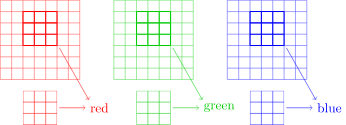

Which result in one final number fo each grid location,

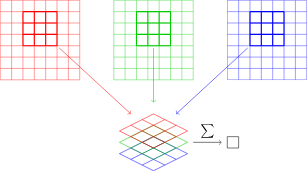


That gives us a ch_out tensor of size ch_in x ks x ks (kernel size), in Pytorch the final dimensions of those weights will then be ch_out x ch_in x ks x ks. The bias is simply a vector of size ch_out.

### Processing color images?
I.e. to HSV, B&W etc. Generally, experiments show that as long as no information is lost in the processing (for example by transforming to black and white), transformations make almost no difference to the model.

# Using FastAI and training on full MNIST dataset

In [58]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path
path.ls()

(#2) [Path('training'),Path('testing')]


PyTorch has it built in. It's called `F.conv2d` (recall that `F` is a fastai import from `torch.nn.functional`, as recommended by PyTorch). The PyTorch docs tell us that it includes these parameters:

- input:: input tensor of shape `(minibatch, in_channels, iH, iW)`
- weight:: filters of shape `(out_channels, in_channels, kH, kW)`

Here `iH,iW` is the height and width of the image (i.e., `28,28`), and `kH,kW` is the height and width of our kernel (`3,3`). But apparently PyTorch is expecting rank-4 tensors for both these arguments, whereas currently we only have rank-2 tensors (i.e., matrices, or arrays with two axes).

Kernels passed to `F.conv2d` need to be rank-4 tensors: `[channels_in, features_out, rows, columns]` , where channels_in is the number of input channels, and features_out is the number of output channels.